In [1]:
%pylab inline
import numpy as np
from tqdm import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
class perceptron(object):
    def __init__(self, input_size, output_size, hl_neurons, hl_layers, learningrate):
        self.learningrate = learningrate
        self.input_size = input_size
        self.output_size = output_size
        self.hl_neurons = hl_neurons
        self.hl_layers = hl_layers
        
        # Now setup the weights in this format (inputs x neurons)
        self.weights = []
        self.ths = []
        self.weights.append(self.get_weights((hl_neurons, input_size)))
        self.ths.append(self.get_weights((hl_neurons, 1)))
        for i in xrange(1, hl_layers):
            self.weights.append(self.get_weights((hl_neurons, hl_neurons)))
            self.ths.append(self.get_weights((hl_neurons, 1)))
        self.weights.append(self.get_weights((output_size, hl_neurons)))
        self.ths.append(self.get_weights((output_size, 1)))
        self.delta_func = self.delta_func1
        self.sigmoid = np.vectorize(self.sigmoid)
        self.sigmoid_delta = np.vectorize(self.sigmoid_delta)
        
    def get_weights(self, dimensions):
        return np.random.normal(0,1,dimensions)
        
    def delta_func1(self, output, truths):
        return (output-truths)
    
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def sigmoid_delta(self, z):
        return (np.exp(-z))/((1+np.exp(-z))**2)
    
    def push_forward(self, inputs):
        A = []
        Z = []
        output = inputs
        for i in xrange(0, len(self.weights)):
#             print "performing %f * %f + %f" % (np.max(self.weights[i]), np.max(output), np.max(self.ths[i]))
            normno = len(output)
            output = np.dot(self.weights[i], output)
            output /= normno
#             print "Dividing by %d neurons" % normno
            output += self.ths[i]
            Z.append(output)
            output = self.sigmoid(output)
            A.append(output)
        return A, Z, output
    
    def feed_forward(self, inputs):
        print "input = %s" % (inputs)
        _, _, output = self.push_forward(inputs)
        return output
    
    def multiply_and_average(self, delta, A):
        At = np.transpose(A)
        # Multiply the two, see if they're compatible (faster than throwing an exception)
        _ = np.dot(delta,At)
        ws = []
        for i in xrange(0, len(delta[0])):
            di = delta[:,[i]]
            Ai = At[[i],:]
            ws.append(np.dot(di, Ai))
        return np.mean(ws,axis=0)
    
    def train(self, inputs, truths):
        # First get the error and delta for output layer
        A, Z, output = self.push_forward(inputs)
#         curdelta = np.multiply((output - truths),self.sigmoid_delta(Z[len(Z)-1]))
        curdelta = np.multiply(self.delta_func(output, truths),self.sigmoid_delta(Z[len(Z)-1]))
        deltas = [curdelta]
        for i in reversed(xrange(0, len(self.weights)-1)):
            curdelta = np.multiply(np.dot(np.transpose(self.weights[i+1]), curdelta),
                                   self.sigmoid_delta(Z[i]))
            deltas.insert(0, curdelta)        
        A.insert(0,inputs)
        for i in reversed(xrange(0, len(self.weights))):
            self.weights[i] -= (self.learningrate * np.dot(deltas[i], A[i].T))
            tmp = np.mean(deltas[i],axis=1)
            tmp = np.matrix(tmp)
            tmp = tmp.T
            try:
                self.ths[i] -= (self.learningrate * tmp)
            except ValueError:
#                 print "tmp - %s" % tmp
#                 print "ths - %s" % self.ths[i]
                self.ths[i] -= (self.learningrate * tmp.T)
            
        return np.mean(abs(truths - output))

In [3]:
input_XOR = np.transpose(np.array([[0,0],[0,1],[1,0],[1,1]]))
gtruth_XOR = np.transpose(np.array([[0],[1],[1],[0]]))
input_AND = np.transpose(np.array([[0,0],[0,1],[1,0],[1,1]]))
gtruth_AND = np.transpose(np.array([[0],[0],[0],[1]]))

input = [[0 0 1 1]
 [0 1 0 1]]
Final Results: [[ 0.50989372  0.50090598  0.49967721  0.49047048]]
Wall time: 279 ms


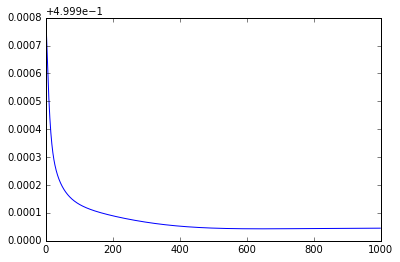

In [4]:
%%time
np.random.seed(1)
pp = perceptron(2, 1, 1, 1, 1.0)
results = []
for i in xrange(0, 1000): results.append(pp.train(input_XOR, gtruth_XOR))
plot(results)
print "Final Results: %s" % pp.feed_forward(input_XOR)